## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

/home/azarius/envs/hse-proj-py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

In [3]:
from tqdm import tqdm

In [4]:
from datetime import datetime

In [5]:
import torch.nn.functional as F

In [6]:
!pwd

/home/azarius/Projects


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
!ls /content/drive/MyDrive/iad_project/

ls: cannot access '/content/drive/MyDrive/iad_project/': No such file or directory


## Data Plot

In [9]:
data = pd.read_csv('./tinkoff-data/FB.csv')

In [10]:
data.head()

,open,high,low,close,volume,time
0,206.9,206.9,206.9,206.9,1,2019-12-23 07:00:00+00:00
1,206.1,206.1,206.1,206.1,1,2019-12-23 07:01:00+00:00
2,204.9,204.9,204.9,204.9,8,2019-12-23 07:04:00+00:00
3,205.0,205.0,205.0,205.0,1,2019-12-23 07:07:00+00:00
4,205.0,205.0,205.0,205.0,41,2019-12-23 07:08:00+00:00


In [11]:
data.shape

(457781, 6)

In [12]:
# data['unix_time'] = data.time.apply(lambda x: (datetime.strptime(x[:-6], '%Y-%m-%d %H:%M:%S') - datetime(1970, 1, 1)).total_seconds())

In [13]:
data.drop(columns=['time'], inplace=True)

In [14]:
data = data.astype('float32')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457781 entries, 0 to 457780
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    457781 non-null  float32
 1   high    457781 non-null  float32
 2   low     457781 non-null  float32
 3   close   457781 non-null  float32
 4   volume  457781 non-null  float32
dtypes: float32(5)
memory usage: 8.7 MB


In [16]:
data.head(10)

,open,high,low,close,volume
0,206.899994,206.899994,206.899994,206.899994,1.0
1,206.100006,206.100006,206.100006,206.100006,1.0
2,204.899994,204.899994,204.899994,204.899994,8.0
3,205.000000,205.000000,205.000000,205.000000,1.0
4,205.000000,205.000000,205.000000,205.000000,41.0
5,205.000000,205.000000,205.000000,205.000000,5.0
6,205.000000,205.000000,205.000000,205.000000,3.0
7,205.000000,205.000000,204.940002,204.940002,16.0
8,205.300003,205.300003,205.199997,205.199997,41.0
9,205.130005,205.990005,205.130005,205.990005,12.0


In [17]:
# data.iloc[0].unix_time

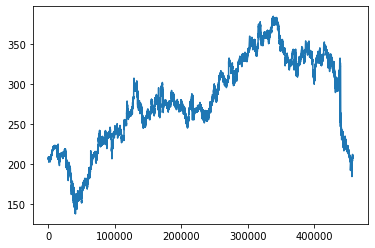

In [18]:
plt.plot(data.close.values)

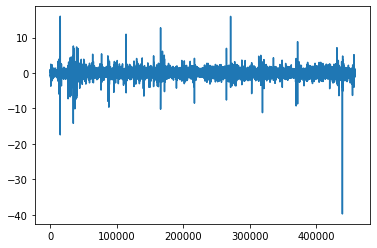

In [19]:
plt.plot(data.close.diff().values)
plt.show()

## Dataloading

In [20]:
class TsCNNDataset(Dataset):
    def __init__(self, raw_data_df, window_size):
        self.raw_data_df = raw_data_df[['open', 'high', 'low', 'volume', 'close']]#, 'unix_time']]
        self.window_size = window_size

    def __len__(self):
        return self.raw_data_df.shape[0] - self.window_size

    def __getitem__(self, idx):
        start = idx
        end = idx + self.window_size
        # return self.raw_data_df.iloc[start:end].values, self.raw_data_df.iloc[end]['close']
        return torch.tensor(np.swapaxes(self.raw_data_df.iloc[start:end].diff().dropna().values, 0, 1)), torch.tensor(self.raw_data_df.iloc[end]['close']), torch.tensor(self.raw_data_df.iloc[end-1]['close'])
        # return [self.raw_data_df.iloc[start:end]['open'].values, self.raw_data_df.iloc[start:end]['high'].values, self.raw_data_df.iloc[start:end]['low'].values, self.raw_data_df.iloc[start:end]['close'].values, self.raw_data_df.iloc[start:end]['volume'].values, self.raw_data_df.iloc[start:end]['unix_time'].values], self.raw_data_df.iloc[end]['close']

In [21]:
class TsLSTMDataset(Dataset):
    def __init__(self, raw_data_df, window_size):
        self.raw_data_df = raw_data_df[['open', 'high', 'low', 'volume', 'close']]
        self.window_size = window_size

    def __len__(self):
        return self.raw_data_df.shape[0] - self.window_size

    def __getitem__(self, idx):
        start = idx
        end = idx + self.window_size
        return self.raw_data_df.iloc[start:end].diff().dropna().values, self.raw_data_df.iloc[end]['close'], self.raw_data_df.iloc[end-1]['close']

## Model

In [22]:
class tsLSTM(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers#,
#             dropout=0.2
        )
        
        self.regressor = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
#         self.lstm.flattern_parameters()
        
        _, (hidden, _) = self.lstm(x)
        
        return self.regressor(hidden[-1])

class tsCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 10, 360)
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(10, 20, 360)
        self.conv3 = nn.Conv1d(20, 30, 120)
        self.conv4 = nn.Conv1d(30, 40, 10)
        self.fc1 = nn.Linear(400, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        # print(x.shape)
        # bias = x[:-1:-1]
        # print(bias.shape)
        # print(bias)
        # x = torch.diff(x)
        # print('input', x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        # print('conv1', x.shape)
        x = self.pool(x)
        # print('pool1', x.shape)

        x = self.conv2(x)
        x = F.relu(x)
        # print('conv2', x.shape)
        x = self.pool(x)
        # print('pool2', x.shape)

        x = self.conv3(x)
        x = F.relu(x)
        # print('conv3', x.shape)
        x = self.pool(x)
        # print('pool3', x.shape)

        x = self.conv4(x)
        x = F.relu(x)
        # print('conv3', x.shape)
        x = self.pool(x)
        # print('pool3', x.shape)
        x = torch.flatten(x, 1)
        # print('flatten', x.shape)

        x = self.fc1(x)
        x = F.relu(x)
        # print('fc1', x.shape)

        x = self.fc2(x)
        x = F.relu(x)
        # print('fc2', x.shape) 

        x = self.fc3(x)
        return x# + bias

        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        

In [23]:
class TSPredictor():
              
    def __init__(self, needLoad = False, path_to_model=None, model_type = None, window_size=3600):
        self.window_size = window_size
        self.isModelrained = False
        self.model_type = model_type
        self.y_true = None
        self.y_pred = None
        
        self.max_plt = None
        self.min_plt = None
        
        if needLoad:

            if model_type == 'CNN':
                self.model = tsCNN()

            if model_type == 'LSTM':
                self.model = tsLSTM(n_features=5)
                
            self.model.load_state_dict(torch.load(path_to_model))
            self.model.eval()
            self.isModelrained = True

        else:
            if model_type == 'CNN':
                self.model = tsCNN()
            if model_type == 'LSTM':
                self.model = tsLSTM(n_features=5)
  
    def train(self, num_epochs = 5, learning_rate=0.01, data_df=None, test_start_idx=285016, BATCH_SIZE = 512):
    
        self.min_plt = data_df.close.min()
        self.max_plt = data_df.close.max()
        
        print('preprocess data')
        if self.model_type == 'CNN':
            dataset = TsCNNDataset(data_df, self.window_size)
        if self.model_type == 'LSTM':
            dataset = TsLSTMDataset(data_df, self.window_size)

        train_split = Subset(dataset, range(test_start_idx))
        test_split = Subset(dataset, range(test_start_idx, len(dataset)))
        train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=False)
        test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.model.to('cuda');

        for epoch in range(num_epochs):
            self.y_true = data_df.close.values.copy()
            self.y_pred = data_df.close.values.copy()
            i = 3600
            tepoch = tqdm(train_batches, unit="batch")
            self.model.train()
            for inputs, targets, bias in tepoch:
                # break
#                 print(inputs.shape)
                inputs = inputs.to('cuda')
                targets = targets.to('cuda')
                bias = torch.unsqueeze(bias, 1)
                bias = bias.to('cuda')
                optimizer.zero_grad()
                pred = self.model(inputs)
                pred = pred + bias
                loss = criterion(pred, targets)

                pred = pred.detach().cpu().numpy()
                # print(pred.shape)
                # print(pred)
                # print(bias.detach().cpu().numpy().shape)
                # assert False
                self.y_pred[i:i+pred.shape[0]] = pred.flatten().copy()
                # print(i)
                # print(i + pred.flatten().shape[0])
                # print(pred.flatten().shape)

                i += pred.shape[0]
                # print(i)
                # assert False

                tepoch.set_description("loss: « %s »" % str(loss.detach().cpu().numpy()))
                loss.backward()
                optimizer.step()

            tepoch = tqdm(test_batches, unit="batch")
            self.model.eval()
            optimizer.zero_grad()
            for inputs, targets, bias in tepoch:
                inputs = inputs.to('cuda')
                targets = targets.to('cuda')
                bias = torch.unsqueeze(bias, 1)
                bias = bias.to('cuda')
                pred = self.model(inputs)
                pred = pred + bias

                pred = pred.detach().cpu().numpy()
                # print(pred.flatten())
                self.y_pred[i:i+pred.shape[0]] = pred.flatten()
                i += pred.shape[0]         

            plt.axvline(x=test_start_idx, c='r', linestyle='--')
            plt.ylim(self.min_plt, self.max_plt)

            plt.plot(self.y_pred, color='orange')
            plt.plot(self.y_true, color='blue')

            plt.suptitle('Time-Series Prediction')
            plt.show()


        self.model.eval()
        self.model.to('cpu')
        self.isModelrained = True

    def save_model(self, path):
        self.model.eval()
        self.model.to('cpu')
        torch.save(self.model.state_dict(), path)
        self.isModelrained = True
        print('model saved to ' + path)    
    
    def inference_df(self, df):
        if not self.isModelrained:
            print('model is not trained')
            return None
        else:
            if df.shape[0] != self.window_size:
                print('incorrect input df shape')
                return None
            else:
                bias = df.close.values[-1]
                data = df[['open', 'high', 'low', 'volume', 'close']].diff().dropna()
                vals = data.values

                if self.model_type == 'CNN':
                    vals = np.swapaxes(vals, 0, 1)
                vals = np.expand_dims(vals, axis=0)
                
                print(vals.shape)
                return self.model(torch.tensor(vals)).detach().cpu().numpy()[0][0] + bias
  
    def inference_dict(self, d):
        pass

  

In [24]:
predictor = TSPredictor(needLoad=True, model_type='CNN', path_to_model='./FB_CNN.pt')

In [ ]:
predictor = TSPredictor(needLoad=False, model_type='CNN')

In [25]:
data.head()

,open,high,low,close,volume
0,206.899994,206.899994,206.899994,206.899994,1.0
1,206.100006,206.100006,206.100006,206.100006,1.0
2,204.899994,204.899994,204.899994,204.899994,8.0
3,205.000000,205.000000,205.000000,205.000000,1.0
4,205.000000,205.000000,205.000000,205.000000,41.0


preprocess data


  0%|                                                 | 0/70 [00:00<?, ?batch/s]/home/azarius/envs/hse-proj-py38/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
loss: « 72.20869 »:  99%|███████████████████▋| 69/70 [03:27<00:02,  2.99s/batch]/home/azarius/envs/hse-proj-py38/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2392])) that is different to the input size (torch.Size([2392, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████| 42/42 [02:04<00:00,  2.95s/batch]


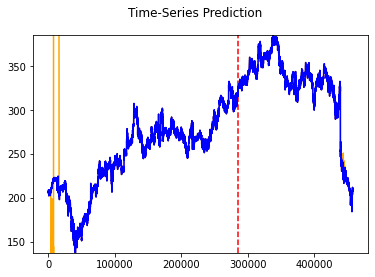

In [26]:
predictor.train(data_df=data, num_epochs=1, BATCH_SIZE=4096)#192 4096)

In [27]:
predictor.save_model('./FB_CNN.pt')

model saved to ./FB_CNN.pt


In [28]:
y_true = predictor.y_true
y_pred = predictor.y_pred

In [29]:
from sklearn.metrics import mean_absolute_error

In [30]:
mean_absolute_error(y_true, y_pred)

61094.023

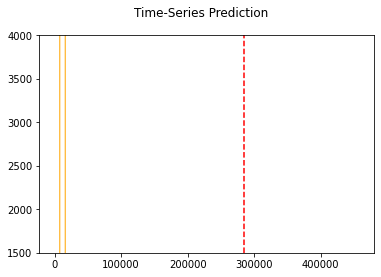

In [31]:
plt.axvline(x=285016, c='r', linestyle='--')
plt.ylim(1500, 4000)

plt.plot(y_true, color='blue', linewidth=1)
plt.plot(y_pred, color='orange', linewidth=1)


plt.suptitle('Time-Series Prediction')
plt.show()

In [32]:
# counter = 0
# for i in range(len(y_true)):
#     if y_pred[i] != y_true[i]:
#         counter += 1
# #         print(i, y_pred[i], y_true[i])
# #     if i > 100:
# #         break
# print(counter)
# print(len(y_true))

In [33]:
# predictor.isModelrained = True

In [26]:
predictor.inference_df(data[:3600])

(1, 5, 3599)


209.66759

In [35]:
# predictor.save_model('/content/drive/MyDrive/iad_project/LSTM.pt')

In [36]:
# data[:3600].close.diff().shape

In [37]:
# data[:3600].close

In [38]:
# data[:3600].close.diff().dropna()

In [39]:
# 86.300003 - 86.699997